# Henry Gas Solubility Optimization (HGSO)
Based on the paper: [Henry gas solubility optimization: A novel physics-based algorithm](https://www.sciencedirect.com/science/article/abs/pii/S0167739X19306557)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import time

In [2]:
def f(X):
  if len(X.shape) <= 1:
    return np.sum(np.abs(X * np.sin(X) + .1*X))
  return np.sum(np.abs(X * np.sin(X) + .1*X), axis=1)

In [147]:
#### CONFIG ####
N = 50
CLUSTER = 5
DIMENSION = 30
ITERATION = 1000
l1 = 5e-2
l2 = 100
l3 = 1e-2
T0 = 298.15
K = 1
alpha = 1
beta = 1

Initialisation

In [178]:
def initialization(X_min, X_max, seed=2):
  np.random.seed(seed)
  r = np.random.rand(CLUSTER, DIMENSION, int(N/CLUSTER))
  X = X_min + r*(X_max - X_min)

  H = l1 * np.random.rand(CLUSTER, 1)

  P = l2 * np.random.rand(CLUSTER, int(N/CLUSTER))

  C = l3 * np.random.rand(CLUSTER, 1)
  return X, H, P, C

Evaluation

In [163]:
def evaluate(X):
  fitness = f(X)

  _local_best = np.argmin(fitness, axis=1)


  temp = np.where(fitness == np.min(fitness))
  _global_best = (temp[0][0], temp[1][0])

  loc_best_X = []
  for k in range(len(_local_best)):
    loc_best_X.append(X[k, :, _local_best[k]])
  loc_best_X = np.array(loc_best_X)

  glob_best_X = X[_global_best[0], :, _global_best[1]]

  glob_best_X = np.tile(glob_best_X, (CLUSTER, int(N/CLUSTER), 1))
  glob_best_X = glob_best_X.reshape((CLUSTER, DIMENSION, int(N/CLUSTER)))
  best_fitness = fitness[_global_best]
  return fitness, loc_best_X, glob_best_X, best_fitness

Update Henry’s coefficient

In [164]:
def getF(value):
  values = [-1, 1]
  return values[value-1]

In [165]:
def update_henry(H, C, T0, iter, iteration):
  # Update Henry’s coefficient
  return H * np.exp(-C * (1/np.exp(-iter/iteration) - 1/T0))

In [166]:
def update_solubility(H, K, P):
  # Update solubility
  return K * H * P

In [167]:
def update_position(X, S, fitness, loc_best_X, glob_best_X, best_fitness):
  epsilon = .05
  F = getF(int(2*np.random.rand()+1))
  gama = beta * np.exp((best_fitness + epsilon) / (fitness + epsilon))
  gama = gama.reshape(X.shape[0],1, X.shape[2])
  loc_best_X = loc_best_X.reshape(X.shape[0], X.shape[1], 1)
  S = S.reshape(X.shape[0],1, X.shape[2])
  r = np.random.rand(CLUSTER, DIMENSION, int(N/CLUSTER))
  X = X + F*r*gama*(loc_best_X - X) + F*r*alpha*(S*glob_best_X - X)
  return X

In [168]:
def worst_agent(X, G_min, G_max):
  # Escape from local optimum and Update the position of the worst agents.
    c1, c2 = .1, .2
    n_w = int(X.shape[0]*X.shape[2] * (np.random.rand()*(c2 - c1) + c1))

    # Get the n_w worst agents
    fitness = f(X)
    flat = fitness.flatten()
    indices = np.argpartition(flat, -n_w)[-n_w:]
    indices = indices[np.argsort(-flat[indices])]
    worst_indices = np.unravel_index(indices, fitness.shape)
    
    # Update worst agent
    r = np.random.rand(X.shape[1])
    for k in range(n_w):
      X[worst_indices[0][k], :, worst_indices[1][k]] = G_min + r*(G_max - G_min)
    
    fitness, _, _, _ = evaluate(X)
    return X, fitness

In [169]:
def HGSO(X, X_min, X_max, H, C, P, K, fitness, loc_best_X, glob_best_X, best_fitness, T0, iter, ITERATION):
    # Update Henry’s coefficient
    H = update_henry(H, C, T0, iter, ITERATION)

    # Update solubility
    S = update_solubility(H, K, P)

    # update position
    X = update_position(X, S, fitness, loc_best_X, glob_best_X, best_fitness)

    # Get the best solution in the swarm
    fitness, loc_best_X, t_glob_best_X, t_best_fitness = evaluate(X)
    if t_best_fitness < best_fitness:
      best_fitness = t_best_fitness
      glob_best_X = t_glob_best_X

    # Escape from local optimum and Update the position of the worst agents.
    G_min, G_max = X_min, X_max
    X, fitness = worst_agent(X, G_min, G_max)
    return X, fitness, loc_best_X, glob_best_X, best_fitness

Computation time: 0.405420
Best is 2.074656e-104


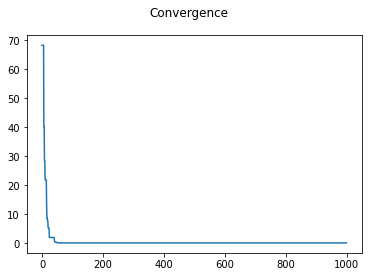

In [208]:
the_best = []
X_min, X_max = -10, 10
X, H, P, C = initialization(X_min, X_max)
fitness, loc_best_X, glob_best_X, best_fitness = evaluate(X)

tic = time.time()
for iter in range(1, ITERATION+1):
  X, fitness, loc_best_X, glob_best_X, best_fitness = HGSO(X, -10, 10, H, C, P, K, fitness, loc_best_X, glob_best_X, best_fitness, T0, iter, ITERATION)
  the_best.append(best_fitness)

toc = time.time()
print("Computation time: {:f}".format(toc-tic))
print("Best is {:e}".format(the_best[-1]))
plt.suptitle("Convergence")
plt.plot(the_best)